# mcu_modeling
This notebook begins with the baseline_model from *mcu_baseline_creation* and uses the lessons learned in *basic_tuning*, to iteratively modify and train sucessive models until no more improvements are possible.

Parameters/Layers to tune:
- Number of Units/Filters per Layer
- Regularlization (Dropout)
- 4x4 CNN design

Additional Evaluation:
- Watched/Unwatched Train/Test Dataset


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import metric_functions as mf

Using TensorFlow backend.


# Compile and Create Image Data <a id='data'></a>

### Identify Working Directory

In [2]:
# dataset with 60% of non-MCU frames removed from Training data
working_directory = 'mixed_frames_remove_60'

In [3]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 5111 images in the Train set
There are 2285 images in the Test set


There are 2419 MCU images in the train set
There are 2692 non-MCU images in the train set
There are 604 MCU images in the test set
There are 1681 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 4090,
    color_mode = 'grayscale',
    subset = 'training')

val_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1021,
    color_mode = 'grayscale',
    subset = 'validation')

Found 4090 images belonging to 2 classes.
Found 1021 images belonging to 2 classes.


In [5]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2285 images belonging to 2 classes.


In [6]:
class_labels = ['Non-MCU', 'MCU']
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)
train_y = np.reshape(train_labels[:,0], (4090,1))
val_y = np.reshape(val_labels[:,0], (1021,1))
test_y = np.reshape(test_labels[:,0], (2285,1))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_images shape: (4090, 128, 128, 1)
train_labels shape: (4090, 2)
val_images shape: (1021, 128, 128, 1)
val_labels shape: (1021, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


# Models <a id='models'></a>

## Baseline Model

As a baseline, we create and train the baseline model design, with a maximum CNN of 6x6, and using Training data with 60% of non-MCU images removed.

In [7]:
model_baseline = models.Sequential()
model_baseline.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Flatten())
model_baseline.add(layers.Dense(64, activation='relu'))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [8]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline = model_baseline.fit(train_images,
                                    train_y,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images, val_y),
                                    callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.7034 - acc: 0.5381 - val_loss: 0.6714 - val_acc: 0.5994
Epoch 2/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6802 - acc: 0.5731 - val_loss: 0.6821 - val_acc: 0.5818
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6643 - acc: 0.6071 - val_loss: 0.6130 - val_acc: 0.6641
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6480 - acc: 0.6257 - val_loss: 0.6201 - val_acc: 0.6523
Epoch 5/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6298 - acc: 0.6557 - val_loss: 0.5844 - val_acc: 0.6993
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6008 - acc: 0.6831 - val_loss: 0.5797 - val_acc: 0.6925
Epoch 7/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.5806 - acc: 0.7042 - val_loss: 0.5287 - val_acc: 0.7532
Epoch 8/50
409

Accuracy 
 Train: 0.879, Test: 0.723
Loss 
 Train: 0.297, Test: 0.574 



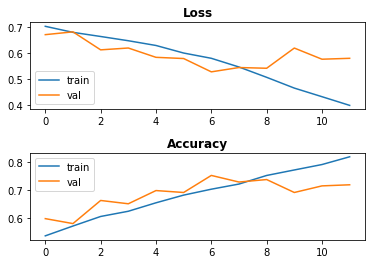



Confusion Matrix, without normalization


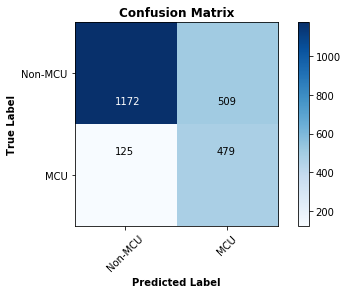



              precision    recall  f1-score   support

     Non-MCU       0.90      0.70      0.79      1681
         MCU       0.48      0.79      0.60       604

    accuracy                           0.72      2285
   macro avg       0.69      0.75      0.69      2285
weighted avg       0.79      0.72      0.74      2285



In [9]:
print(mf.evaluate_test(model_baseline, history_baseline, class_labels, train_images, test_images, train_y, test_y))

## Model 1

With the baseline statistics available (79% recall on MCU, and 30% chance of False Positive for a non-MCU), we increase the number of filters/units in the Hidden and Activation Layers. Increasing these had a positive impact on MCU recall during the Basic Tuning exercise.

- x4 Hidden Layer Filters
- x2 Activation Layer Units

In [10]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [11]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_1 = model_1.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.8036 - acc: 0.5279 - val_loss: 0.6869 - val_acc: 0.5788
Epoch 2/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.7178 - acc: 0.5281 - val_loss: 0.6844 - val_acc: 0.5661
Epoch 3/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6953 - acc: 0.5663 - val_loss: 0.6436 - val_acc: 0.6366
Epoch 4/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6499 - acc: 0.6242 - val_loss: 0.6236 - val_acc: 0.6719
Epoch 5/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6378 - acc: 0.6416 - val_loss: 0.6184 - val_acc: 0.6660
Epoch 6/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6137 - acc: 0.6795 - val_loss: 0.5829 - val_acc: 0.6993
Epoch 7/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.5943 - acc: 0.6919 - val_loss: 0.5738 - val_acc: 0.7013
Epoch 8/50
409

Accuracy 
 Train: 0.907, Test: 0.726
Loss 
 Train: 0.225, Test: 0.693 



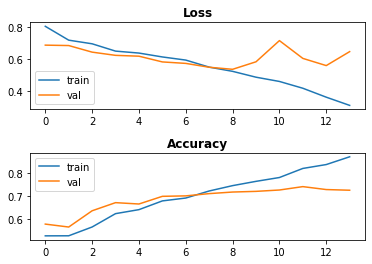



Confusion Matrix, without normalization


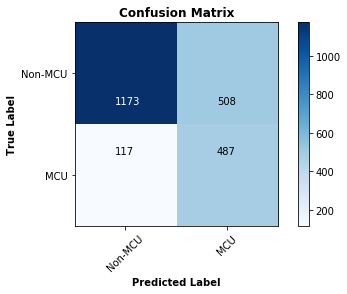



              precision    recall  f1-score   support

     Non-MCU       0.91      0.70      0.79      1681
         MCU       0.49      0.81      0.61       604

    accuracy                           0.73      2285
   macro avg       0.70      0.75      0.70      2285
weighted avg       0.80      0.73      0.74      2285



In [12]:
print(mf.evaluate_test(model_1, history_1, class_labels, train_images, test_images, train_y, test_y))

## Model 2

We accept a small improvement in MCU recall to 81% recall (and unchanged 30% chance of False Positive for a non-MCU). We see if there's more improvement to be found by doubling the amount of filters/units in the CNN Hidden and classifier Activation Layers.

- x8 Hidden Layer Filters
- x4 Activation Layer Units

In [13]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (6, 6), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(256, (5, 5), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(512, (4, 4), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [14]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_2 = model_2.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 16s 4ms/step - loss: 1.4249 - acc: 0.5227 - val_loss: 0.6912 - val_acc: 0.5269
Epoch 2/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.7211 - acc: 0.5306 - val_loss: 0.6699 - val_acc: 0.6180
Epoch 3/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.6913 - acc: 0.5875 - val_loss: 0.6230 - val_acc: 0.6641
Epoch 4/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.6488 - acc: 0.6374 - val_loss: 0.6234 - val_acc: 0.6954
Epoch 5/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.6348 - acc: 0.6418 - val_loss: 0.6237 - val_acc: 0.6660
Epoch 6/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.6287 - acc: 0.6599 - val_loss: 0.6024 - val_acc: 0.6758
Epoch 7/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.6049 - acc: 0.6812 - val_loss: 0.5761 - val_acc: 0.7101
Epoch 8

Accuracy 
 Train: 0.976, Test: 0.782
Loss 
 Train: 0.062, Test: 0.858 



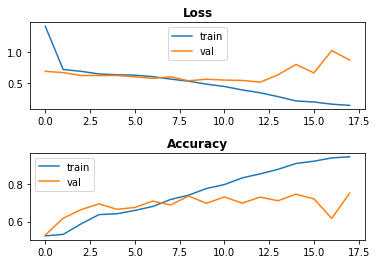



Confusion Matrix, without normalization


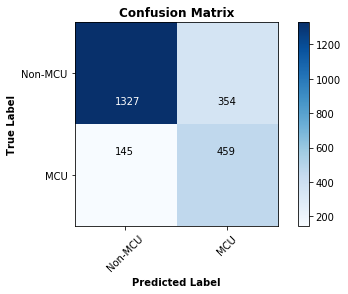



              precision    recall  f1-score   support

     Non-MCU       0.90      0.79      0.84      1681
         MCU       0.56      0.76      0.65       604

    accuracy                           0.78      2285
   macro avg       0.73      0.77      0.74      2285
weighted avg       0.81      0.78      0.79      2285



In [15]:
print(mf.evaluate_test(model_2, history_2, class_labels, train_images, test_images, train_y, test_y))

## Model 3
Doubling the units in Model 2 results in a reduction to the False Positive rate (30% to 21%), but also a reduction in MCU recall. For now, we'll bring the number of filters/units back in line with Model 1, but then see how these interact with a doubling of filters at the Input Layer.

- x2 Input Layer Units
- x4 Hidden Layer Units
- x2 Activation Layer Units

In [16]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [17]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_3 = model_3.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.7434 - acc: 0.5225 - val_loss: 0.6914 - val_acc: 0.5269
Epoch 2/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6920 - acc: 0.5389 - val_loss: 0.6443 - val_acc: 0.6709
Epoch 3/50
4090/4090 [==============================] - 12s 3ms/step - loss: 0.6786 - acc: 0.6108 - val_loss: 0.6373 - val_acc: 0.6376
Epoch 4/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6511 - acc: 0.6377 - val_loss: 0.6440 - val_acc: 0.6210
Epoch 5/50
4090/4090 [==============================] - 12s 3ms/step - loss: 0.6325 - acc: 0.6501 - val_loss: 0.5967 - val_acc: 0.6944
Epoch 6/50
4090/4090 [==============================] - 12s 3ms/step - loss: 0.5989 - acc: 0.6836 - val_loss: 0.6429 - val_acc: 0.6934
Epoch 7/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.5799 - acc: 0.7005 - val_loss: 0.6049 - val_acc: 0.6807
Epoch 8

Accuracy 
 Train: 0.973, Test: 0.800
Loss 
 Train: 0.082, Test: 0.776 



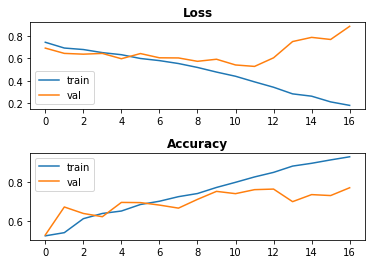



Confusion Matrix, without normalization


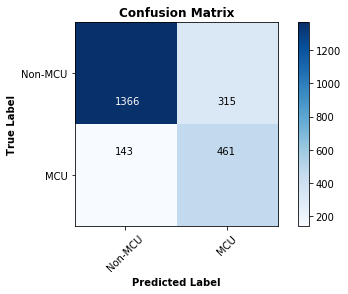



              precision    recall  f1-score   support

     Non-MCU       0.91      0.81      0.86      1681
         MCU       0.59      0.76      0.67       604

    accuracy                           0.80      2285
   macro avg       0.75      0.79      0.76      2285
weighted avg       0.82      0.80      0.81      2285



In [18]:
print(mf.evaluate_test(model_3, history_3, class_labels, train_images, test_images, train_y, test_y))

## Model 4
Doubling filters at the Input Layer again resulted in an equal hit to MCU recall, but there was a better reduction in False Positives. Let's combine the changes for Model 2 (x8 Hidden and x4 Activation) and Model 3 (x2 Input), to see how they interact:
- x2 Input Layer Units
- x8 Hidden Layer Units
- x4 Activation Layer Units

In [19]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (6, 6), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(256, (5, 5), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(512, (4, 4), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [20]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_4 = model_4.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 20s 5ms/step - loss: 0.8774 - acc: 0.5098 - val_loss: 0.6837 - val_acc: 0.5201
Epoch 2/50
4090/4090 [==============================] - 18s 4ms/step - loss: 0.7081 - acc: 0.5154 - val_loss: 0.6812 - val_acc: 0.5269
Epoch 3/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.6874 - acc: 0.5311 - val_loss: 0.6793 - val_acc: 0.5269
Epoch 4/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.6853 - acc: 0.5836 - val_loss: 0.6459 - val_acc: 0.6533
Epoch 5/50
4090/4090 [==============================] - 18s 4ms/step - loss: 0.6483 - acc: 0.6421 - val_loss: 0.6133 - val_acc: 0.6787
Epoch 6/50
4090/4090 [==============================] - 18s 4ms/step - loss: 0.6361 - acc: 0.6604 - val_loss: 0.6125 - val_acc: 0.7062
Epoch 7/50
4090/4090 [==============================] - 18s 4ms/step - loss: 0.6059 - acc: 0.6719 - val_loss: 0.5997 - val_acc: 0.7120
Epoch 8

Accuracy 
 Train: 0.896, Test: 0.707
Loss 
 Train: 0.254, Test: 0.663 



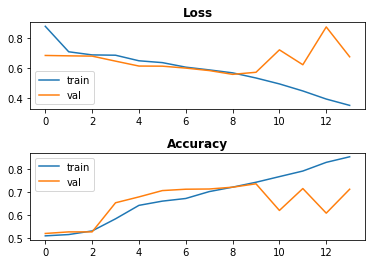



Confusion Matrix, without normalization


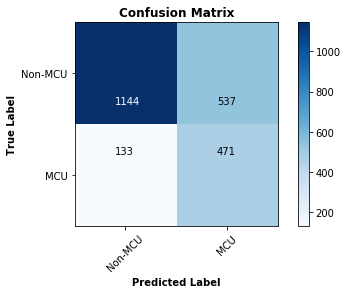



              precision    recall  f1-score   support

     Non-MCU       0.90      0.68      0.77      1681
         MCU       0.47      0.78      0.58       604

    accuracy                           0.71      2285
   macro avg       0.68      0.73      0.68      2285
weighted avg       0.78      0.71      0.72      2285



In [21]:
print(mf.evaluate_test(model_4, history_4, class_labels, train_images, test_images, train_y, test_y))

## Model 5

After trying various numbers of filters/units per layer, we produced various models with various Recall and False Positive rates. During the Basic Tuning exercise, regularization and normalization had the effect of reducing False Positives and Recall, so we're proceeding with the model with highest MCU Recall, Model 1, with 81% Recall and 30% False Positives. We'll apply 50% Dropout both before the Flatten layer and after the classifier's relu activation layer.

- x4 Hidden Layer Filters
- x2 Activation Layer Units
- Double Dropout (before Flatten and after classifer Activation)

In [24]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(Dropout(.5))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(128, activation='relu'))
model_5.add(Dropout(.5))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [25]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_5 = model_5.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.7112 - acc: 0.5274 - val_loss: 0.6801 - val_acc: 0.5269
Epoch 2/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6894 - acc: 0.5423 - val_loss: 0.6670 - val_acc: 0.6778
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6699 - acc: 0.6144 - val_loss: 0.6131 - val_acc: 0.6934
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6447 - acc: 0.6440 - val_loss: 0.6051 - val_acc: 0.6592
Epoch 5/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6276 - acc: 0.6663 - val_loss: 0.6142 - val_acc: 0.6944
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6186 - acc: 0.6780 - val_loss: 0.5638 - val_acc: 0.7199
Epoch 7/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.5864 - acc: 0.7022 - val_loss: 0.6928 - val_acc: 0.6210
Epoch 8/50
409

Accuracy 
 Train: 0.959, Test: 0.729
Loss 
 Train: 0.105, Test: 0.965 



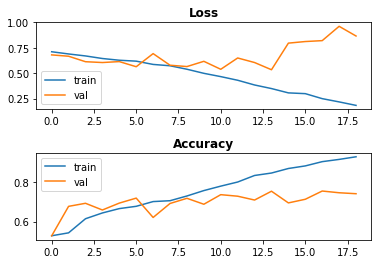



Confusion Matrix, without normalization


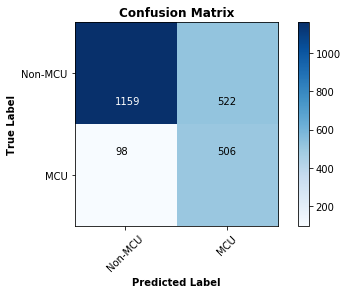



              precision    recall  f1-score   support

     Non-MCU       0.92      0.69      0.79      1681
         MCU       0.49      0.84      0.62       604

    accuracy                           0.73      2285
   macro avg       0.71      0.76      0.70      2285
weighted avg       0.81      0.73      0.74      2285



In [26]:
print(mf.evaluate_test(model_5, history_5, class_labels, train_images, test_images, train_y, test_y))

## Model 6

Two dropout layers produced the highest recall yet, 84%, but lots of False Positives. Let's try just one Dropout layer, after the classifier's Activiation layer.

- x4 Hidden Layer Filters
- x2 Activation Layer Units
- Dropout after classifer Activation Layer

In [27]:
model_6 = models.Sequential()
model_6.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_6.add(layers.MaxPooling2D((2, 2)))

model_6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

model_6.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

model_6.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

model_6.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

model_6.add(layers.Flatten())
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(Dropout(.5))
model_6.add(layers.Dense(1, activation='sigmoid'))

model_6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [28]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_6 = model_6.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 12s 3ms/step - loss: 0.7191 - acc: 0.5210 - val_loss: 0.6938 - val_acc: 0.5269
Epoch 2/50
4090/4090 [==============================] - 12s 3ms/step - loss: 0.7136 - acc: 0.5543 - val_loss: 0.6934 - val_acc: 0.4858
Epoch 3/50
4090/4090 [==============================] - 12s 3ms/step - loss: 0.6818 - acc: 0.5494 - val_loss: 0.6317 - val_acc: 0.6768
Epoch 4/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6585 - acc: 0.6296 - val_loss: 0.6509 - val_acc: 0.6259
Epoch 5/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6403 - acc: 0.6487 - val_loss: 0.6106 - val_acc: 0.6572
Epoch 6/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6154 - acc: 0.6738 - val_loss: 0.5965 - val_acc: 0.6856
Epoch 7/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.5977 - acc: 0.6829 - val_loss: 0.5979 - val_acc: 0.6895
Epoch 8

Accuracy 
 Train: 0.961, Test: 0.788
Loss 
 Train: 0.125, Test: 0.647 



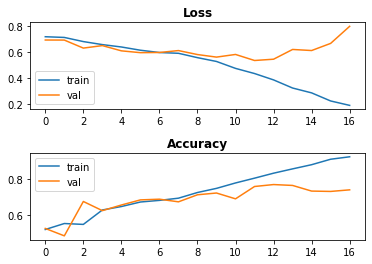



Confusion Matrix, without normalization


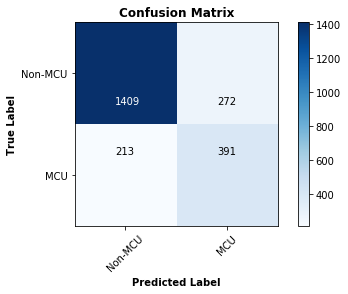



              precision    recall  f1-score   support

     Non-MCU       0.87      0.84      0.85      1681
         MCU       0.59      0.65      0.62       604

    accuracy                           0.79      2285
   macro avg       0.73      0.74      0.74      2285
weighted avg       0.79      0.79      0.79      2285



In [29]:
print(mf.evaluate_test(model_6, history_6, class_labels, train_images, test_images, train_y, test_y))

## Model 7

Dropdown after the classifier's Activation Layer brought MCU Recall down to 65%, so we won't proceed with any regularization or normalization.

Before we accept Model 1 as the final tuned model, we'll just try its tuning in a 4x4 network design. During creation of the baseline models, it was nearly a tie between the 6x6 and 4x4 models, and the 6x6 only narrowly edged out the 4x4 model.
- 4x4 (remove 6x6 and 5x5 
- x4 Hidden Layer Filters
- x2 Activation Layer Units

In [32]:
model_7 = models.Sequential()
model_7.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_7.add(layers.MaxPooling2D((2, 2)))

model_7.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))

model_7.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))

model_7.add(layers.Flatten())
model_7.add(layers.Dense(128, activation='relu'))
model_7.add(layers.Dense(1, activation='sigmoid'))

model_7.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [33]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_7 = model_7.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 20s 5ms/step - loss: 0.8763 - acc: 0.5149 - val_loss: 0.6994 - val_acc: 0.5269
Epoch 2/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.7048 - acc: 0.5384 - val_loss: 0.6712 - val_acc: 0.5681
Epoch 3/50
4090/4090 [==============================] - 18s 4ms/step - loss: 0.7002 - acc: 0.5645 - val_loss: 0.6416 - val_acc: 0.6592
Epoch 4/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.6544 - acc: 0.6254 - val_loss: 0.6499 - val_acc: 0.6082
Epoch 5/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.6185 - acc: 0.6555 - val_loss: 0.5989 - val_acc: 0.6670
Epoch 6/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.5815 - acc: 0.7017 - val_loss: 0.5601 - val_acc: 0.7101
Epoch 7/50
4090/4090 [==============================] - 17s 4ms/step - loss: 0.5305 - acc: 0.7328 - val_loss: 0.5693 - val_acc: 0.7140
Epoch 8

Accuracy 
 Train: 0.897, Test: 0.692
Loss 
 Train: 0.246, Test: 0.717 



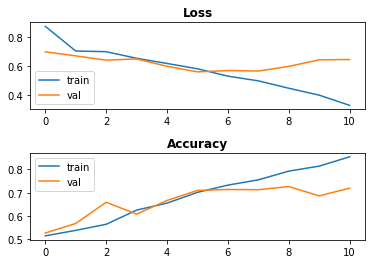



Confusion Matrix, without normalization


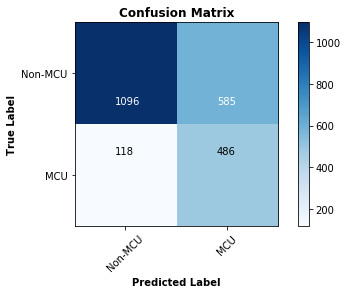



              precision    recall  f1-score   support

     Non-MCU       0.90      0.65      0.76      1681
         MCU       0.45      0.80      0.58       604

    accuracy                           0.69      2285
   macro avg       0.68      0.73      0.67      2285
weighted avg       0.78      0.69      0.71      2285



In [34]:
print(mf.evaluate_test(model_7, history_7, class_labels, train_images, test_images, train_y, test_y))

This 4x4 model performed similarly to its 6x6 counterpart with MCU Recall, but much worse in terms of False Positives. We'll accept the 6x6 Model 1 as the final model.

In [31]:
model_1.save('saved_models/tuned_model')

# Training Model 1's Design with a "Watched"/"Unwatched" Train/Test Split
For additional evaluation of this model design, we can change the train/test configuration. Whereas all the other models in this notebook were trained on frames from 40 movies, and tested on frames from those same movies, this model is being trained on frames from 32 movies and tested on frames from 8 separate movies.

Testing on "Unwatched" movies is probaBly closer to the real use-case of this project. However, for initial development of this project, those additional 8 movies (an additional 25%) was built into the training data of the primary dataset, to provide as much variety in movies as possible.

### Identify Working Directory

In [6]:
working_directory = 'unseen_frames_remove_60'

In [7]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 6127 images in the Train set
There are 2358 images in the Test set


There are 2891 MCU images in the train set
There are 3236 non-MCU images in the train set
There are 674 MCU images in the test set
There are 1684 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 4090,
    color_mode = 'grayscale',
    subset = 'training')

val_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1021,
    color_mode = 'grayscale',
    subset = 'validation')

Found 4902 images belonging to 2 classes.
Found 1225 images belonging to 2 classes.


In [9]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2358 images belonging to 2 classes.


In [10]:
class_labels = ['Non-MCU', 'MCU']
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)
train_y = np.reshape(train_labels[:,0], (4090,1))
val_y = np.reshape(val_labels[:,0], (1021,1))
test_y = np.reshape(test_labels[:,0], (2285,1))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_images shape: (4090, 128, 128, 1)
train_labels shape: (4090, 2)
val_images shape: (1021, 128, 128, 1)
val_labels shape: (1021, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


## Model 8

This model is identical to the best performing model, Model 1, but trained on a different dataset. Whereas all the other models in this notebook were trained on frames from 40 movies, and tested on frames from those same movies, this model is being trained on frames from 32 movies and tested on frames from 8 separate movies.

- x4 Hidden Layer Filters
- x2 Activation Layer Units
- Tested on "Unwatched" dataset

In [11]:
model_8 = models.Sequential()
model_8.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Flatten())
model_8.add(layers.Dense(128, activation='relu'))
model_8.add(layers.Dense(1, activation='sigmoid'))

model_8.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [12]:
%%time
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_8 = model_8.fit(train_images,
                         train_y,
                         epochs=50,
                         batch_size=50,
                         validation_data=(val_images, val_y),
                         callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 10s 2ms/step - loss: 0.7611 - acc: 0.5244 - val_loss: 0.6986 - val_acc: 0.5260
Epoch 2/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6919 - acc: 0.5496 - val_loss: 0.6844 - val_acc: 0.5671
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6911 - acc: 0.5858 - val_loss: 0.6260 - val_acc: 0.6268
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6608 - acc: 0.6293 - val_loss: 0.6466 - val_acc: 0.6523
Epoch 5/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6393 - acc: 0.6440 - val_loss: 0.7409 - val_acc: 0.5739
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6191 - acc: 0.6699 - val_loss: 0.5774 - val_acc: 0.7258
Epoch 7/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6142 - acc: 0.6753 - val_loss: 0.5726 - val_acc: 0.7032
Epoch 8/50
40

Accuracy 
 Train: 0.883, Test: 0.727
Loss 
 Train: 0.294, Test: 0.567 



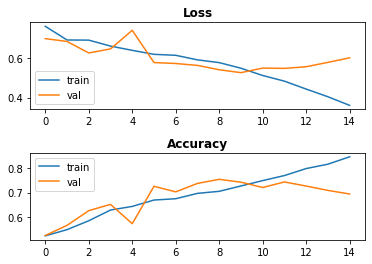



Confusion Matrix, without normalization


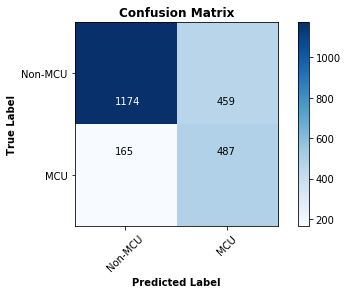



              precision    recall  f1-score   support

     Non-MCU       0.88      0.72      0.79      1633
         MCU       0.51      0.75      0.61       652

    accuracy                           0.73      2285
   macro avg       0.70      0.73      0.70      2285
weighted avg       0.77      0.73      0.74      2285



In [13]:
print(mf.evaluate_test(model_8, history_8, class_labels, train_images, test_images, train_y, test_y))

This model performed slightly worse than Model 1, with MCU recall of 75% (vs. 81%) but with a mildly improved False Positive rate of 28% (vs. 30%).

In [2]:
# this may need to be run each time a Jupyter notebook server is started
pip install Pillow --user

     |████████████████████████████████| 2.1MB 1.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# this may need to be run each time a Jupyter notebook server is started
pip install keras --user

     |████████████████████████████████| 378kB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.3MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# this may need to be run each time a Jupyter notebook server is started
pip install sklearn --user

     |████████████████████████████████| 7.3MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 307kB 1.7MB/s eta 0:00:01
Failed to build sklearn
    Running setup.py install for sklearn ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
